## Ejercicio 3: Análisis de Series Temporales de Bolsa

Usando el dataset de Yahoo Finance para el índice S&P 500 (^GSPC)

In [1]:
# Importamos las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

# Configuración básica de visualización
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

# Para evitar warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Obtener datos de los últimos 5 años
# Calculamos las fechas
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

# Descargamos los datos usando yfinance directamente
ticker = yf.Ticker('^GSPC')
df = ticker.history(start=start_date, end=end_date)

print("Primeras 5 filas del dataset:")
df.head()

Primeras 5 filas del dataset:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-30 00:00:00-05:00,3256.449951,3285.909912,3242.800049,3283.659912,3790350000,0.0,0.0
2020-01-31 00:00:00-05:00,3282.330078,3282.330078,3214.679932,3225.520020,4529700000,0.0,0.0
2020-02-03 00:00:00-05:00,3235.659912,3268.439941,3235.659912,3248.919922,3760460000,0.0,0.0
2020-02-04 00:00:00-05:00,3280.610107,3306.919922,3280.610107,3297.590088,3996900000,0.0,0.0
2020-02-05 00:00:00-05:00,3324.909912,3337.580078,3313.750000,3334.689941,4121480000,0.0,0.0


In [3]:
# 2. Calcular retornos

# Retornos diarios
df['daily_return'] = df['Close'].pct_change()

# Retornos semanales
df['weekly_return'] = df['Close'].pct_change(periods=5)

# Retornos mensuales (aproximadamente 21 días de trading)
df['monthly_return'] = df['Close'].pct_change(periods=21)

print("Estadísticas descriptivas de los retornos:")
df[['daily_return', 'weekly_return', 'monthly_return']].describe()

Estadísticas descriptivas de los retornos:


,daily_return,weekly_return,monthly_return
count,1255.000000,1251.000000,1235.000000
mean,0.000579,0.002842,0.011790
std,0.013473,0.027132,0.054008
min,-0.119841,-0.179666,-0.329668
25%,-0.005310,-0.009257,-0.011567
50%,0.000907,0.005073,0.020376
75%,0.007350,0.017389,0.043092
max,0.093828,0.173974,0.251144


Los 10 días con mayor volatilidad:
Date
2020-03-16 00:00:00-04:00    0.119841
2020-03-12 00:00:00-04:00    0.095113
2020-03-24 00:00:00-04:00    0.093828
2020-03-13 00:00:00-04:00    0.092871
2020-03-09 00:00:00-04:00    0.075970
2020-04-06 00:00:00-04:00    0.070331
2020-03-26 00:00:00-04:00    0.062414
2020-03-17 00:00:00-04:00    0.059955
2020-06-11 00:00:00-04:00    0.058944
2022-11-10 00:00:00-05:00    0.055434
Name: daily_return, dtype: float64


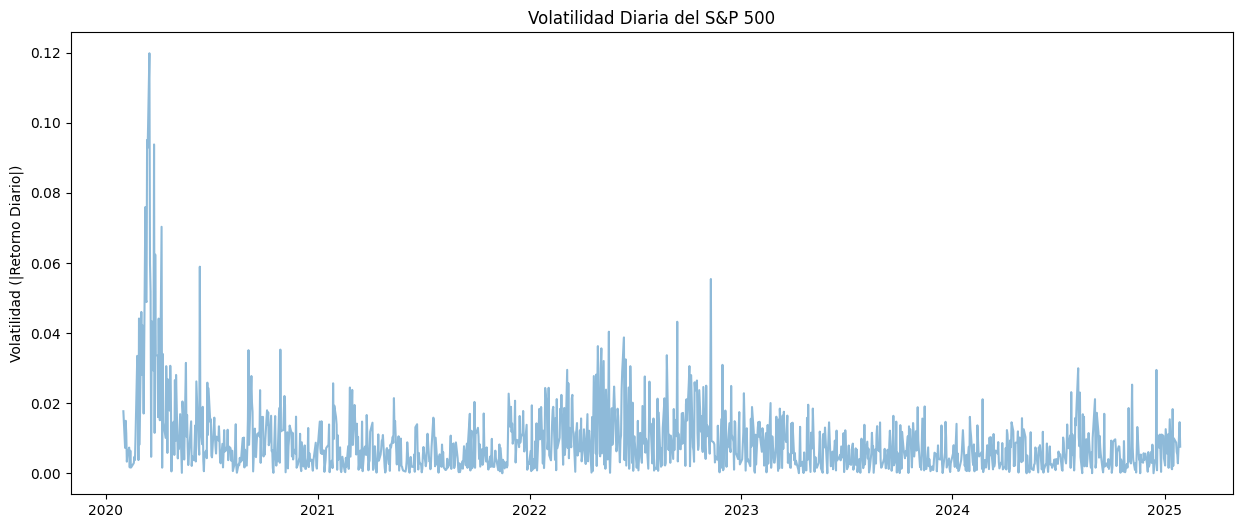

In [4]:
# 3. Identificar los 10 días con mayor volatilidad
volatility_days = df['daily_return'].abs().sort_values(ascending=False).head(10)

print("Los 10 días con mayor volatilidad:")
print(volatility_days)

# Visualización de la volatilidad
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['daily_return'].abs(), alpha=0.5)
plt.title('Volatilidad Diaria del S&P 500')
plt.ylabel('Volatilidad (|Retorno Diario|)')
plt.show()

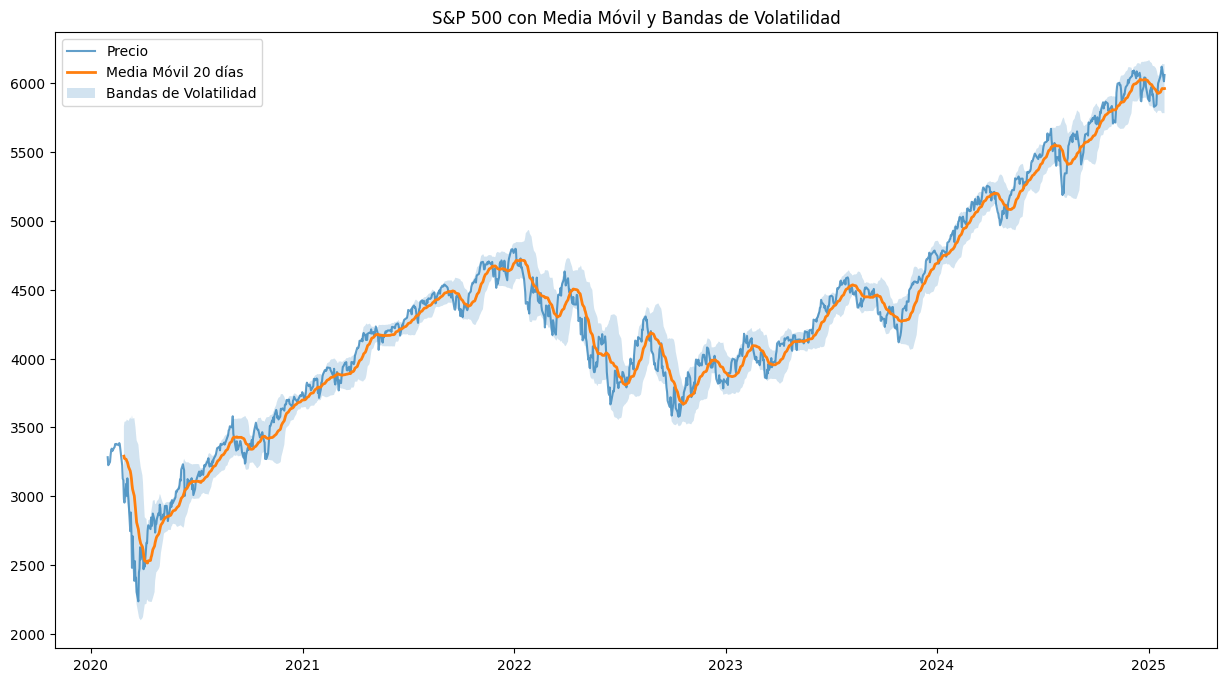

In [5]:
# 4. Implementar ventana móvil de 20 días

# Media móvil
df['MA20'] = df['Close'].rolling(window=20).mean()

# Desviación estándar móvil
df['STD20'] = df['Close'].rolling(window=20).std()

# Máximos y mínimos móviles
df['MAX20'] = df['Close'].rolling(window=20).max()
df['MIN20'] = df['Close'].rolling(window=20).min()

# Visualización
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['Close'], label='Precio', alpha=0.7)
plt.plot(df.index, df['MA20'], label='Media Móvil 20 días', linewidth=2)
plt.fill_between(df.index, 
                 df['MA20'] - 2*df['STD20'], 
                 df['MA20'] + 2*df['STD20'], 
                 alpha=0.2, 
                 label='Bandas de Volatilidad')
plt.title('S&P 500 con Media Móvil y Bandas de Volatilidad')
plt.legend()
plt.show()

In [6]:
# 5. Crear indicadores técnicos

def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calcular RSI
df['RSI'] = calculate_rsi(df['Close'])

# Calcular MACD
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

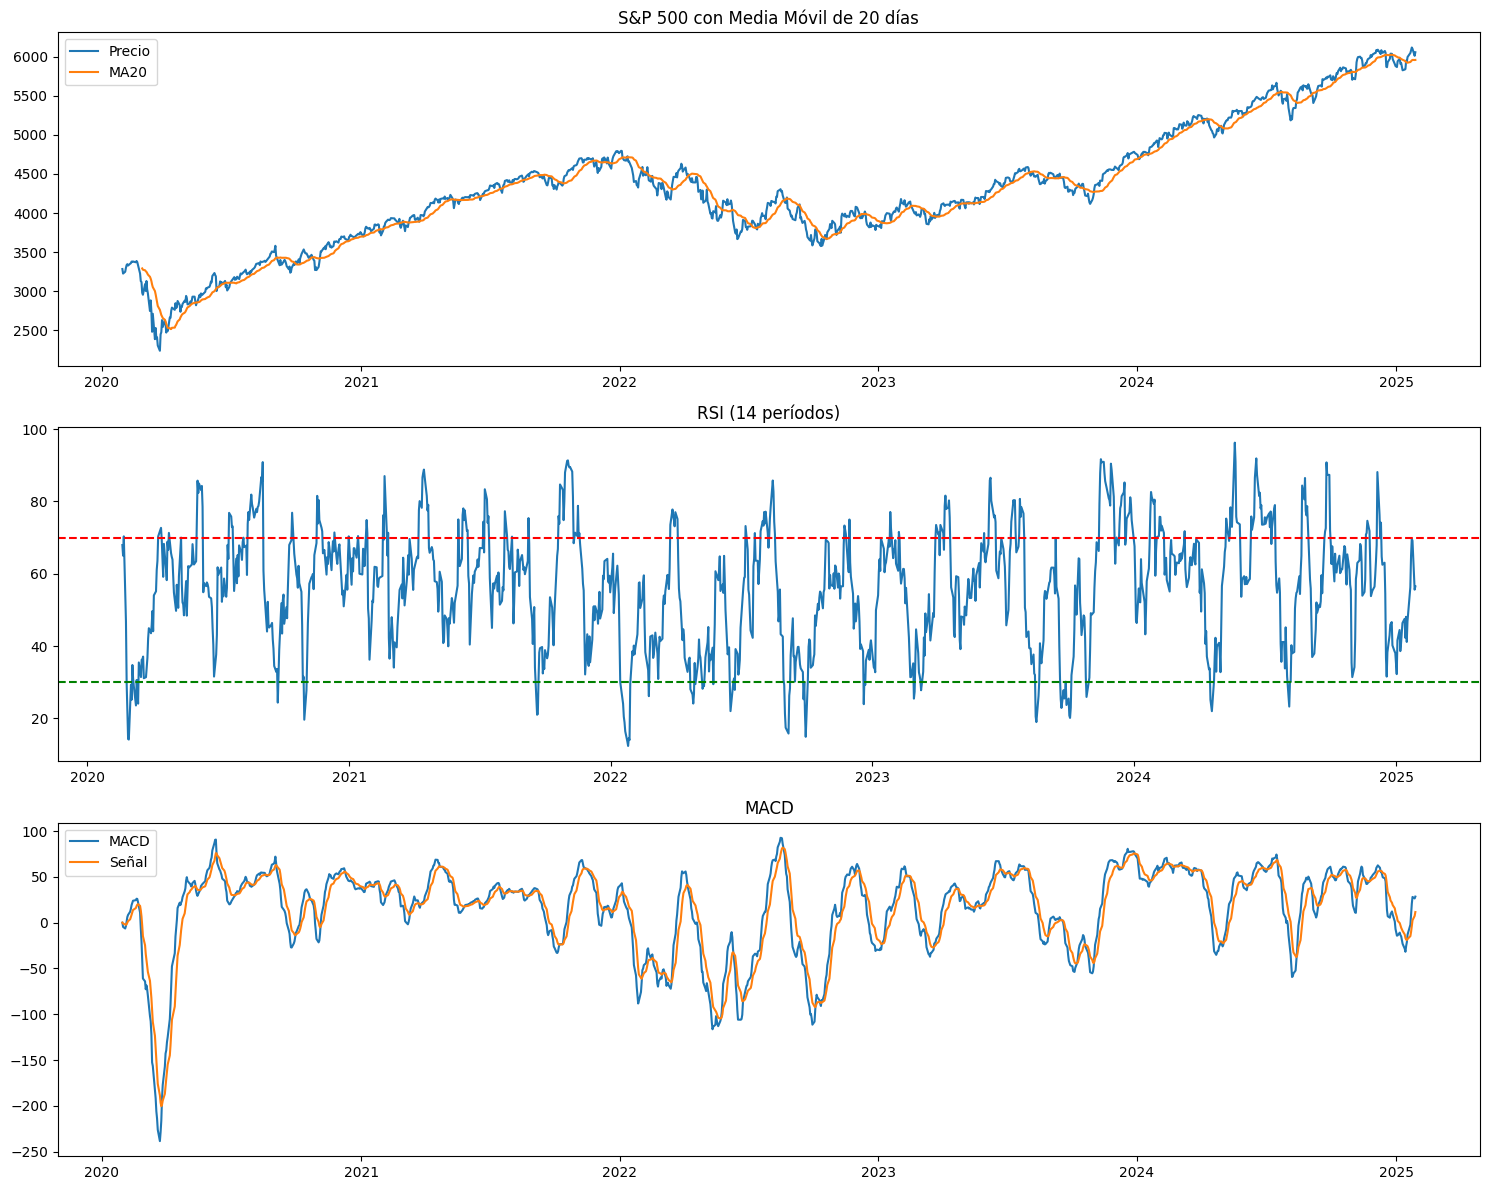

In [7]:
# 6. Visualizar indicadores
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Precio y Media Móvil
ax1.plot(df.index, df['Close'], label='Precio')
ax1.plot(df.index, df['MA20'], label='MA20')
ax1.set_title('S&P 500 con Media Móvil de 20 días')
ax1.legend()

# RSI
ax2.plot(df.index, df['RSI'])
ax2.axhline(y=70, color='r', linestyle='--')
ax2.axhline(y=30, color='g', linestyle='--')
ax2.set_title('RSI (14 períodos)')

# MACD
ax3.plot(df.index, df['MACD'], label='MACD')
ax3.plot(df.index, df['Signal Line'], label='Señal')
ax3.set_title('MACD')
ax3.legend()

plt.tight_layout()
plt.show()

### Conclusiones:

1. Hemos analizado los datos del S&P 500 de los últimos 5 años, calculando diferentes tipos de retornos (diarios, semanales y mensuales).

2. Identificamos los días con mayor volatilidad, lo que nos permite detectar eventos significativos en el mercado.

3. Implementamos indicadores técnicos populares:
   - Media móvil de 20 días para identificar tendencias
   - RSI para identificar condiciones de sobrecompra/sobreventa
   - MACD para identificar cambios en la tendencia y momentum

4. Las visualizaciones nos permiten ver claramente:
   - La tendencia general del mercado
   - Períodos de alta volatilidad
   - Señales de compra/venta según los indicadores técnicos